# Assignment 7 
## Objective
Build a Long Short-Term Memory (LSTM) recurrent neural network to predict the current global active power at the time step (t), given prior measurements at the time step (t-1).

# Recurrent Neural Network

## Part 1 - Data Preprocessing

### Importing the libraries

In [43]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import matplotlib.pyplot as plt


### Importing the training set

In [44]:
# Load the dataset
df_original = pd.read_csv('household_power_consumption.txt', sep=';', 
                            parse_dates={'DateTime': ['Date', 'Time']}, 
                            infer_datetime_format=True, 
                            low_memory=False,  # Prevent type inference issues
                            na_values=['?'])   # Treat '?' as NaN

# Cut the data for training time purposes
df = df_original

# Display the first few rows
print("Dataset head:")
display(df.info())

Dataset head:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   DateTime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


None

## Checking for missing data
Filling missing data using forward fill method

In [45]:
# Check for missing values
print("\nMissing values:")
display(df.isnull().sum())

# Fill missing values (e.g., forward-fill)
df.fillna(method='ffill', inplace=True)


Missing values:


DateTime                     0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

## Create Time Sequence

Created reusable functions to prepare the time sequences

In [46]:
# Create sequences function
def prepare_sequences(data, seq_length):
    """Prepare sequences for time series prediction"""
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

def create_sequences(data, seq_length):
    """Create sequences for time series prediction"""
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys) 

In [47]:
#Visualize time series
time = pd.Series(range(len(df))) 

# Set parameters
seq_length = 100  # Number of time steps to look back
train_split = 0.8  # Training data percentage

# Extract and normalize the data
data = df['Global_active_power'].values.reshape(-1, 1)

# Split into train and test sets
train_size = int(len(data) * train_split)
X_train = time[:train_size]
y_train = data[:train_size]
X_test = time[train_size:]
y_test = data[train_size:]

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1660207,)
Test set shape: (415052,)


The sequence length greatly determines the training time and long term sequence. I initially tried to train the model on a yearly basis but it would take over 50 hours to complete the training process. I then reduced it to 100 data points. 

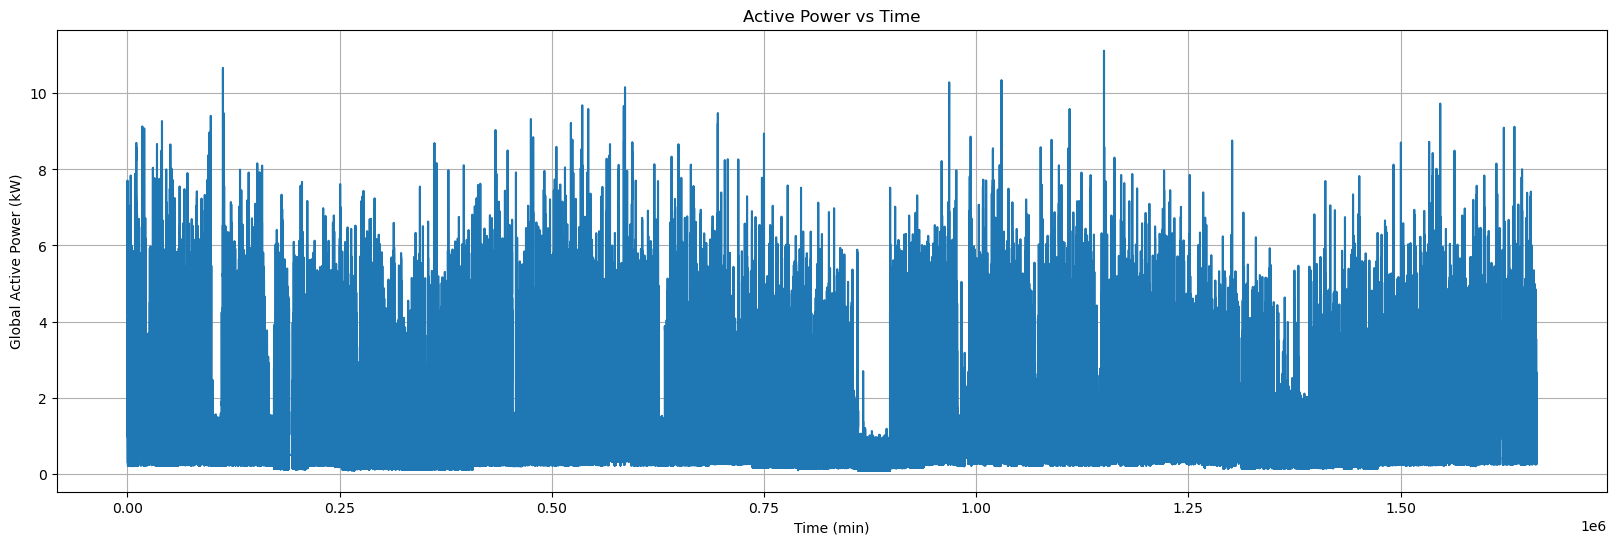

In [48]:
#Visualize the time series data
plt.figure(figsize=(20, 6))  # Width=10 inches, Height=6 inches
plt.plot(X_train, y_train)
plt.xlabel('Time (min)')
plt.ylabel('Global Active Power (kW)')
plt.title('Active Power vs Time')
plt.grid(True)
plt.show()


Looking at the data plotted above, there does not seem to have any obvious correlation. It might be worth noting that there is sudden drop in the middle of the data that could coincide with a storm/ strike which would cause a power outage. 

## Normalization and feature scaling

In [49]:
# Normalize the series using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1)).flatten()
x_valid_scaled = scaler.transform(np.array(y_test).reshape(-1, 1)).flatten()

# Now the data is scaled to the range [0, 1] for both training and validation

# Preparing Features and labels

In [50]:
# parameters
window_size = 100
batch_size = 64
shuffle_buffer_size = 1000

# Define the dataset function to create windowed datasets for training and validation
def window_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Generate the training and validation datasets using the window_dataset function
train_set = window_dataset(x_train_scaled, window_size, batch_size, shuffle_buffer_size)
val_set = window_dataset(x_valid_scaled, window_size, batch_size, shuffle_buffer_size)

## Part 2 - Building and Training the RNN

### Build model
Since the data spans over a couple years and has resolution of 1 minute, I decided to overlook the convolution layer for short term patterns. Instead, I opted for two layers of LSTM before applying a regression layer. 

I also changed the default learning rate to 0.001 to make sure the model does not miss subtle changes. 

There are **dropouts** included to help with overfitting. 

In [ ]:
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Define the model
model = models.Sequential([
    # 1. LSTM Layer for capturing temporal dependencies
    layers.LSTM(64, return_sequences=True, input_shape=[window_size, 1]),
    layers.Dropout(0.2),  # Dropout layer to prevent overfitting
    
    layers.LSTM(64),
    layers.Dropout(0.2),
    
    # 2. Dense Layers for final prediction
    layers.Dense(32, activation="relu"),
    layers.Dense(1)  # Final output layer for regression
])

# Compile the model with Mean Absolute Error (MAE) loss
model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

model.summary()

c:\Users\kylea\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 100, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

Epoch 1/100
  25940/Unknown 1902s 73ms/step - loss: 0.0135

c:\Users\kylea\anaconda3\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


25940/25940 ━━━━━━━━━━━━━━━━━━━━ 2089s 80ms/step - loss: 0.0135 - val_loss: 0.0097
Epoch 2/100
25940/25940 ━━━━━━━━━━━━━━━━━━━━ 2074s 80ms/step - loss: 0.0103 - val_loss: 0.0144
Epoch 3/100
25940/25940 ━━━━━━━━━━━━━━━━━━━━ 1998s 77ms/step - loss: 0.0100 - val_loss: 0.0134
Epoch 4/100
25940/25940 ━━━━━━━━━━━━━━━━━━━━ 2166s 84ms/step - loss: 0.0098 - val_loss: 0.0130
Epoch 5/100
25940/25940 ━━━━━━━━━━━━━━━━━━━━ 2056s 79ms/step - loss: 0.0271 - val_loss: 0.0184
Epoch 6/100
25940/25940 ━━━━━━━━━━━━━━━━━━━━ 1918s 74ms/step - loss: 0.0169 - val_loss: 0.0113
Epoch 7/100
25940/25940 ━━━━━━━━━━━━━━━━━━━━ 1959s 76ms/step - loss: 0.0136 - val_loss: 0.0131
Epoch 8/100
25940/25940 ━━━━━━━━━━━━━━━━━━━━ 1996s 77ms/step - loss: 0.0112 - val_loss: 0.0165
Epoch 9/100
25940/25940 ━━━━━━━━━━━━━━━━━━━━ 2009s 77ms/step - loss: 0.0106 - val_loss: 0.0165
Epoch 10/100
25940/25940 ━━━━━━━━━━━━━━━━━━━━ 2027s 78ms/step - loss: 0.0101 - val_loss: 0.0188
Epoch 11/100
25940/25940 ━━━━━━━━━━━━━━━━━━━━ 2026s 78ms/step

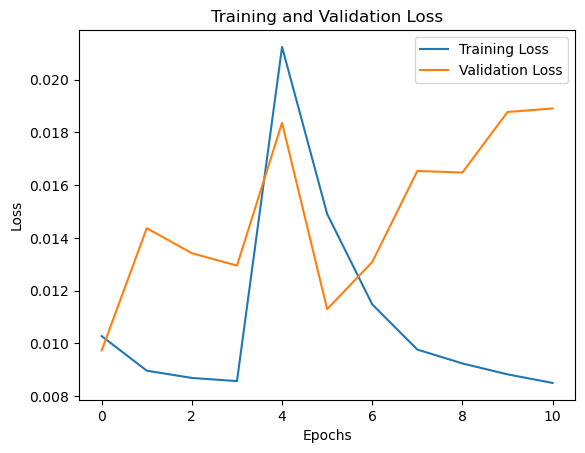

In [52]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with the early stopping callback
history = model.fit(
    train_set,
    epochs=100,
    validation_data=val_set,
    verbose = 1,
    callbacks=[early_stopping]
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

The model took over 6 hours to train thanks to early stopping. 

By applying an epoch count of 100, I was hoping to train it for long enough to detect variations for whole few years. However, early stopping with a patience of 10 stopped and stored the best model at 11 epochs. 

The Validation lossed and training losses are not what you would typically expect, where the loss would decrease gradually as more iterations are carried out. However, the training loss does tend to a lower value as more epochs are reached. 

# Forecasting

In [65]:
# Make predictions on the validation set
predictions_scaled = model.predict(val_set)

# Inverse the scaling of predictions
predictions_rescaled = scaler.inverse_transform(predictions_scaled)

# Extract labels (y_test) from the validation dataset
y_test = []
for _, label in val_set.as_numpy_iterator():
    y_test.extend(label)

# Convert y_test to a NumPy array
y_test = np.array(y_test).reshape(-1, 1)

# Perform inverse scaling on y_test
y_test_rescaled = scaler.inverse_transform(y_test)

# Now you can plot or calculate error metrics for predictions_rescaled vs y_test_rescaled

# Calculate MAE and RMSE on the validation set
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

6484/6484 ━━━━━━━━━━━━━━━━━━━━ 202s 31ms/step


c:\Users\kylea\anaconda3\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Mean Absolute Error (MAE): 0.7632860695659317
Root Mean Squared Error (RMSE): 1.1027162040206708


The results of Mean Absolute Error and Root Mean Square Error are pretty small but they are not insignificant. Since 0.7 over the range of about 9 represents a relative error of 8%, the model can be said to be about 92% accurate. 

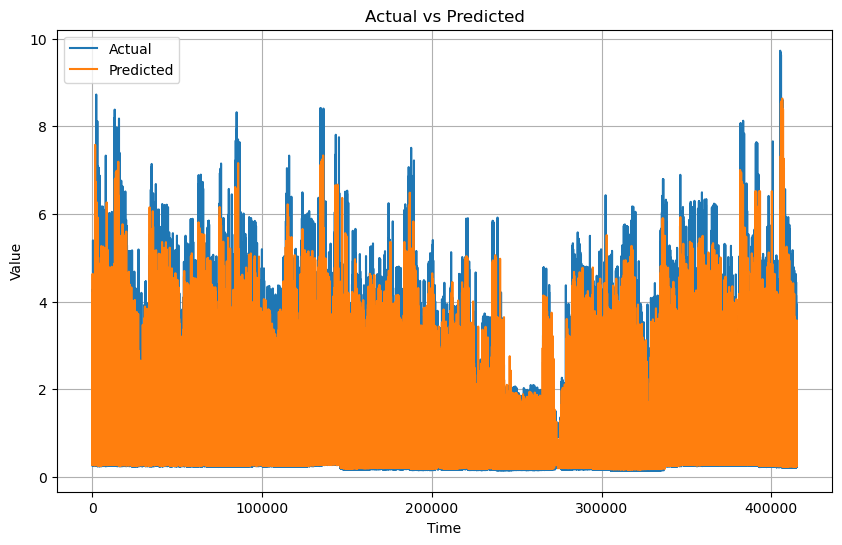

In [73]:
# Align predictions and y_test
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label="Actual")
plt.plot(predictions_rescaled, label="Predicted")
plt.title("Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

This figure shows the prediction on the validation set as compared to the actual data. Generally, the prediction has similar trends as to the actual values, but do not match the same absolute values. To observe the trends closer we can plot the data on zoomed in figure. 

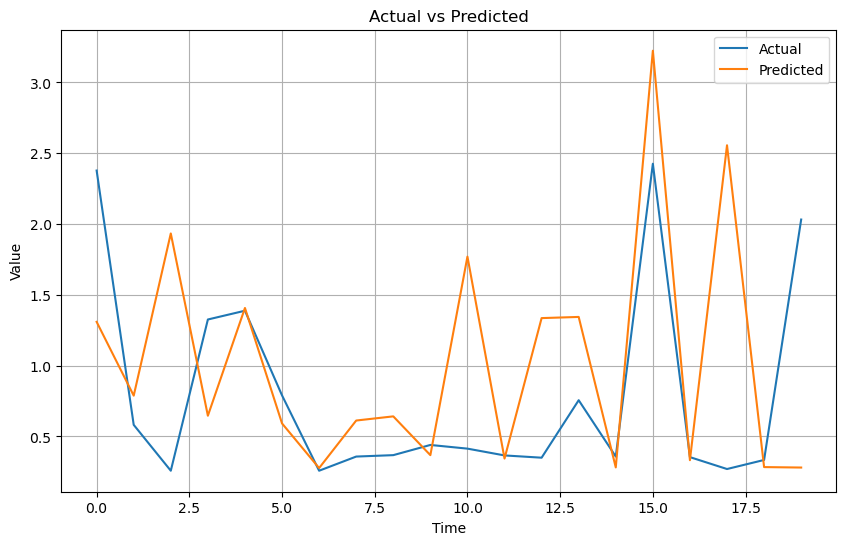

In [75]:
# Align predictions and y_test - zoomed in
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled[:20], label="Actual")
plt.plot(predictions_rescaled[:20], label="Predicted")
plt.title("Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

The zoomed-in data graph shows that the prediction and actual values do not well. The model was able to predict one peak at time 15 though. 

# Observations:
**Pattern Matching:**
The predicted values (orange line) generally follow the overall trend of the actual values (blue line), but there are notable deviations in some regions.
Peaks and troughs are sometimes exaggerated in the predictions compared to the actual data.

**Error Distribution:**
There are moments where the predictions align closely with the actual values, indicating the model captures some temporal dependencies well.
In some cases, the predictions significantly overshoot or undershoot the actual values, suggesting the model struggles with extreme values or variability in the data.

**Noise Handling:**
The model appears to introduce some noise, likely due to insufficient smoothing or overfitting on the training set.

**Lagging Effect:**
Predictions seem to lag slightly behind the actual values in some instances, which may indicate room for improvement in capturing short-term temporal patterns.

# Conclusions:
The model demonstrates an ability to learn general trends in the data but struggles with extreme fluctuations, which may indicate insufficient training or the need for feature engineering.
The root mean squared error (RMSE) and other metrics calculated earlier should guide the quantitative evaluation. From the visual plot, it is clear that further optimization is required.

**To improve performance:**
1. Tune the model architecture by experimenting with additional LSTM layers or attention mechanisms.
2. Adjust hyperparameters like the learning rate, batch size, and the number of epochs.
3. Consider feature engineering or introducing additional features to provide more context to the model.
4. Evaluate the impact of window size on model predictions.